# Importing

In [1]:
import pandas as pd
import numpy as np
import os

# data transform

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import KNNImputer

# models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

# models check
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

# zapisywanie modeli
import joblib

# for load the data pre-preparation function
import importlib.util

# visualization
import seaborn as sns
import matplotlib.pyplot as plt

import os

In [2]:
np.set_printoptions(suppress=False)

work_dir = r'C:\Users\krasavica\Desktop\Projekty - DS\python-project-ApartmentPriceAnalysis'
os.chdir(work_dir)

pd.set_option('display.float_format', '{:.2f}'.format)

In [10]:
# loading functions from the file
module_name = f"pipeline_pre-processing"
module_path = f"pipeline_pre-processing.py"

spec = importlib.util.spec_from_file_location(module_name, module_path)
module = importlib.util.module_from_spec(spec)
spec.loader.exec_module(module)

In [4]:
data_initial = pd.read_csv('data_2024-01.csv', index_col = 0)

In [11]:
data_for_analysis = module.preliminary_transform(data_initial, True)

All the categorizations occurring in the set in multi-vector selection variables were coded.


# Functions for processing data

After applying the **preliminary_transform** function with data preprocessing defined in the file **pipeline_pre-processing.py**, the data must be splited into training and test sets and coded them for modeling.<br>For this purpose, the **prepare_train_test_data** function was defined below. This function:
1. divides the dataset into training and test datasets
2. applies **cleaning_data** function defined in the file **pipeline_pre-processing.py**
3. codes variables for modeling purposes using the following functions defined below:
    * **one_hot_encode_train_test** - One-hot encodes selected categorical features with category dropping for stability.
    * **scale_train_test** - Standardizes numerical features in training and test datasets using z-score normalization.
    * **kNN_impute_train_test** - Performs K-Nearest Neighbors (KNN) imputation on selected features in training and test datasets.



### one_hot_encode

In [5]:
def one_hot_encode_train_test(X_train_to_encode, X_test_to_encode, features_to_onehotencode):
    
    """
    One-hot encodes selected categorical features with category dropping for stability.
    
    Parameters:
    -----------
    X_train_to_encode : pd.DataFrame
        Training data.
    X_test_to_encode : pd.DataFrame
        Test data.
    features_to_onehotencode : list of str
        List of categorical feature names to be one-hot encoded.

    Returns:
    --------
    X_train : pd.DataFrame
        Training data with encoded features.
    X_test : pd.DataFrame
        Test data with encoded features.
    """
    
    # Create copies of the original datasets to avoid modifying them in-place
    X_train = X_train_to_encode.copy()
    X_test = X_test_to_encode.copy()
    
    for column in features_to_onehotencode:
        # Define categories to drop if found
        categories_to_drop = ['nie podano', 'inny', 'wtórny', 'prywatny', 'opolskie']
        
        # Decide which category to drop fot this feature
        cat_to_drop = None
        for cat in categories_to_drop:
            if cat in X_train[column].unique():
                cat_to_drop = [cat]
                break
                
        # Create and fit the encoder
        encoder = OneHotEncoder(drop = cat_to_drop if cat_to_drop else 'first',
                                sparse_output = False,
                                handle_unknown='ignore')
        encoder.fit(X_train[[column]])
        
        # Column names for output
        cols = encoder.get_feature_names_out([column])
        
        # Transform both train and test
        X_train_encoded = pd.DataFrame(encoder.transform(X_train[[column]]), columns=cols, index=X_train.index)
        X_test_encoded = pd.DataFrame(encoder.transform(X_test[[column]]), columns=cols, index=X_test.index)
        
        # Join with original data
        X_train = pd.concat([X_train, X_train_encoded], axis=1)
        X_test = pd.concat([X_test, X_test_encoded], axis=1)
        
    # Drop the original categorical column
    X_train.drop(features_to_onehotencode, axis=1, inplace=True)
    X_test.drop(features_to_onehotencode, axis=1, inplace=True)
    
    return X_train, X_test

### scale

In [6]:
def scale_train_test(X_train_to_scale, X_test_to_scale):
    
    """
    Standardizes numerical features in training and test datasets using StandardScaler.

    This function applies z-score normalization to ensure each feature has a mean of 0
    and standard deviation of 1. It fits the scaler only on the training data and uses
    the same transformation on the test data to avoid data leakage.

    Parameters:
    -----------
    X_train_to_scale : pd.DataFrame
        The training dataset with numerical features to be standardized.

    X_test_to_scale : pd.DataFrame
        The test dataset with the same structure as X_train_to_scale.

    Returns:
    --------
    X_train : pd.DataFrame
        The standardized training dataset.

    X_test : pd.DataFrame
        The standardized test dataset, transformed using the scaler fitted on training data.
    """
    # Create copies of the original datasets to avoid modifying them in-place
    X_train = X_train_to_scale.copy()
    X_test = X_test_to_scale.copy() 
    
    # Create and fit the scaler
    scaler = StandardScaler()

    X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)
    X_test = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns)
        
    return X_train, X_test

### kNN_impute

In [7]:
def kNN_impute_train_test(X_train_to_impute, X_test_to_impute,
                          features_for_kNN_impute, features_to_onehotencode):       
    
    """
    Performs K-Nearest Neighbors (KNN) imputation on selected features in training and test datasets.

    This function uses the KNNImputer to fill in missing values in specified features by
    leveraging similarity between instances. It also automatically handles one-hot encoded
    categorical variables by including all derived columns in the imputation process.

    Parameters:
    -----------
    X_train_to_impute : pd.DataFrame
        Training dataset containing missing values to be imputed.

    X_test_to_impute : pd.DataFrame
        Test dataset with the same structure as the training data.

    features_for_kNN_impute : list of str
        List of original feature names to apply KNN imputation to.
        If a feature has been one-hot encoded, columns after encoding
        will be included in the imputation process.

    Returns:
    --------
    X_train : pd.DataFrame
        Training dataset with missing values imputed using KNN.

    X_test : pd.DataFrame
        Test dataset imputed using the same fitted KNN model from training data.
    """
    
    # Create copies of the original datasets to avoid modifying them in-place
    X_train = X_train_to_impute.copy()
    X_test = X_test_to_impute.copy()
    features_for_kNN_impute_new = features_for_kNN_impute.copy()
    
    # Identify which features were one-hot encoded
    encoded_vars = list(set(features_for_kNN_impute) & set(features_to_onehotencode))
    
    # Replace original variable name with all derived one-hot encoded columns
    for var in encoded_vars:
        col_after_encode = [col for col in X_train.columns if col.startswith(var)]
        features_for_kNN_impute_new.remove(var)
        features_for_kNN_impute_new = features_for_kNN_impute_new + col_after_encode
        
    # Create the imputer
    imputer = KNNImputer()
    
    # Fit and apply KNN imputation to the selected columns
    X_train[features_for_kNN_impute_new] = imputer.fit_transform(X_train[features_for_kNN_impute_new])
    X_test[features_for_kNN_impute_new] = imputer.transform(X_test[features_for_kNN_impute_new])
    
    return X_train, X_test

### prepare_train_test_data

In [8]:
def prepare_train_test_data (data, to_delete_from_test_set, test_size, random_seed):
    
    """
    Prepares and processes the dataset for model training and evaluation by applying
    feature selection, encoding, scaling, and missing value imputation.

    The function loads preprocessing configuration from a saved dictionary and performs the following steps:
    1. Splits the dataset into train and test sets.
    2. Cleans missing and outlier values in train and test sets.
    3. Selects relevant features and target column.
    3. Applies one-hot encoding to categorical features.
    4. Scales numeric features using StandardScaler.
    5. Imputes missing values using K-Nearest Neighbors imputation.

    Parameters:
    -----------
    data : pd.DataFrame
        The full dataset to be prepared for training and testing.
    
    to_delete_from_test_set : bool
        Indicates whether outlier observations will remain in the test set or be removed. Default is set to True.

    test_size : float
        Proportion of the dataset to include in the test split (e.g., 0.2 for 20%).

    random_seed : int
        Random seed to ensure reproducibility of the train-test split.

    Returns:
    --------
    X_train_imputed : pd.DataFrame
        Fully preprocessed training feature set.

    X_test_imputed : pd.DataFrame
        Fully preprocessed test feature set.

    y_train : pd.Series
        Target variable for training data.

    y_test : pd.Series
        Target variable for test data.
    """
    
    # Load preprocessing configuration with selected features and target definition
    model_features_dict = joblib.load("1. Data Preparation/model_features_dict.joblib")
    
    features_to_use = model_features_dict['features_to_use']
    target = model_features_dict['target']
    features_to_onehotencode = model_features_dict['features_to_onehotencode']
    features_for_kNN_impute = model_features_dict['features_for_kNN_impute']
    
    # Validate that all required features exist in the provided dataset
    if all(x in data.columns for x in model_features_dict['features_to_use']) == 0:
        print("The dataset does not have all the variables defined for modeling")
    
    # Split the dataset into training and testing sets
    train_data, test_data = train_test_split(data,
                                             test_size = test_size,
                                             random_state = random_seed)

    # Clean the train and test data
    train_cleaned_data = module.cleaning_data(train_data, train_dataset = True)
    
    test_cleaned_data = module.cleaning_data(test_data,
                                             train_dataset = False,
                                             to_delete_from_test_set = to_delete_from_test_set)
    
    # Since the test set is needed for the evaluation of the model, it must not contain missing data in the target variable
    test_cleaned_data = test_cleaned_data.dropna(subset = target)

    # Extract features (X) and target variable (y)
    X_train = train_cleaned_data[features_to_use]
    y_train = train_cleaned_data[target]

    X_test = test_cleaned_data[features_to_use]
    y_test = test_cleaned_data[target]
    
    # Ensure NaNs are np.nan, not pd.NA
    X_train = X_train.replace({pd.NA: np.nan})
    X_test = X_test.replace({pd.NA: np.nan})
    
    # One-hot encode categorical features
    X_train_encoded, X_test_encoded = one_hot_encode_train_test(X_train, X_test, features_to_onehotencode)
    
    # Scale features using StandardScaler
    X_train_scaled, X_test_scaled = scale_train_test(X_train_encoded, X_test_encoded)
    
    # Impute missing values using KNN imputer
    X_train_imputed, X_test_imputed = kNN_impute_train_test(X_train_scaled, X_test_scaled,
                                                            features_for_kNN_impute, features_to_onehotencode)
    
    return X_train_imputed, X_test_imputed, y_train, y_test

# Data preparation

In [12]:
(X_train,
 X_test_without_outliers,
 y_train,
 y_test_without_outliers) = prepare_train_test_data(data_for_analysis,
                                                    to_delete_from_test_set = True,
                                                    test_size = 0.2, random_seed = 99)

(X_train,
 X_test_with_outliers,
 y_train,
 y_test_with_outliers) = prepare_train_test_data(data_for_analysis,
                                                 to_delete_from_test_set = False,
                                                 test_size = 0.2, random_seed = 99)

modeling_data = {'X_train': X_train,
                 'y_train': y_train,
                 'X_test_without_outliers': X_test_without_outliers,
                 'y_test_without_outliers': y_test_without_outliers,
                 'X_test_with_outliers': X_test_with_outliers,
                 'y_test_with_outliers': y_test_with_outliers}



                  W zbiorze wystąpiły braki w cechach: 'typ budynku', 'powierzchnia',
                  'liczba pokoi', 'rynek', 'ogłoszeniodawca', 'miasto', 'województwo'.
                  Do otrzymania prognozy wszystkie z powyższych cech
                  muszą być wypełnione.
                  Obserwacje te zostały usunięte ze zbioru do predykcji.
                  

                      W zbiorze wystąpiły obserwację o skrajnych wartościach
                      ze względu na zaproponowaną cenę, powierzchnię, piętro lub rok budynku.
                      Obserwacje te zostały usunięte ze zbioru do predykcji.
                      

                  W zbiorze wystąpiły braki w cechach: 'typ budynku', 'powierzchnia',
                  'liczba pokoi', 'rynek', 'ogłoszeniodawca', 'miasto', 'województwo'.
                  Do otrzymania prognozy wszystkie z powyższych cech
                  muszą być wypełnione.
                  Obserwacje te zostały usunięte ze zbioru do predykcj

# Functions for modeling
For model evaluation and selection, 2 functions were defined:
1. **model_summary** - to evaluate and visualize modeling results vs. actual values.
2. **model_selection** - for selecting the best parameters among those given using GridSearchCV.

### model_summary

In [13]:
def model_summary(regressor, title, modeling_data):
    
    X_test_without_outliers = modeling_data['X_test_without_outliers']
    y_test_without_outliers = modeling_data['y_test_without_outliers']
    
    X_test_with_outliers = modeling_data['X_test_with_outliers']
    y_test_with_outliers = modeling_data['y_test_with_outliers']

    list_of_data = [[X_test_without_outliers, y_test_without_outliers],
                    [X_test_with_outliers, y_test_with_outliers]]
    
    fig, ax = plt.subplots(2, 1, figsize=(11, 11))
    
    for i in range(2):
        
        X_test = list_of_data[i][0]
        y_test = list_of_data[i][1]
    
        prediction = regressor.predict(X_test)

        rmse = round(np.sqrt(metrics.mean_squared_error(y_test, prediction)),2)
        r2 = round(metrics.r2_score(y_test, prediction),3)
        n = len(y_test)  # number of observations
        p = len(X_test.columns)  # number of predictors
        adjusted_r2 = round(1 - (1 - r2) * (n - 1) / (n - p - 1),3)
        
        sns.regplot(x = y_test,
                    y = prediction,
                    line_kws=dict(color="r"),
                    scatter_kws=dict(alpha=0.25),
                    ci=85,
                    ax = ax[i])
        # Dodanie linii idealnych przewidywań (y = x)
        min_val = y_test.min()
        max_val = y_test.max()
        sns.lineplot(x = [min_val, max_val], y = [min_val, max_val], ax = ax[i])
        
        ax[i].set_title(title)
        ax[i].set_xlabel("Actual")
        ax[i].set_ylabel("Predict")
        x_lim_max = ax[i].get_xlim()[1]
        y_lim_max = ax[i].get_ylim()[1]
        ax[i].text(x_lim_max**0.75,
                   y_lim_max*0.75,
                   f'Wskaźniki:\nRMSE:{"{:,}".format(rmse)} zł\nR^2:{r2}\nAdj.R^2:{adjusted_r2}')
    
    plt.subplots_adjust(left=0.1,
                        bottom=0.1, 
                        right=0.9, 
                        top=0.87, 
                        wspace=0.15, 
                        hspace=0.45)
    
    plt.show()

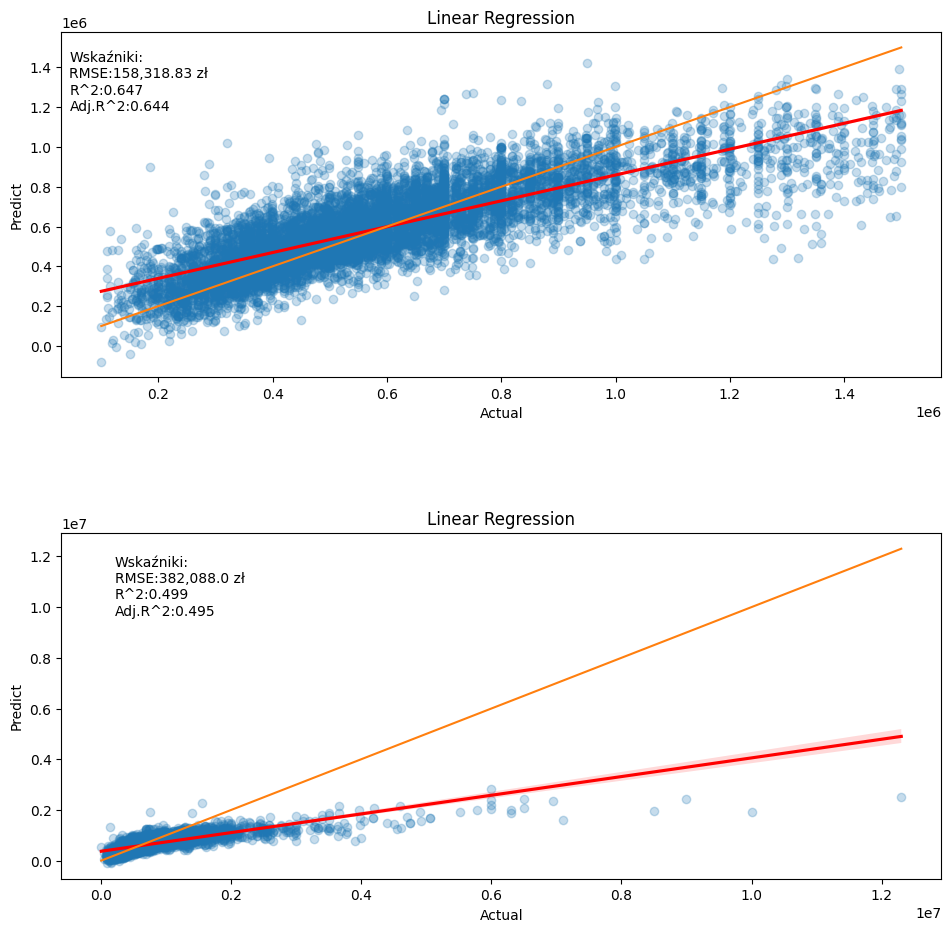

In [14]:
X_train = modeling_data['X_train']
y_train = modeling_data['y_train']

linear = LinearRegression(n_jobs=-2)
linear.fit(X_train, y_train)

model_summary(linear, "Linear Regression", modeling_data)

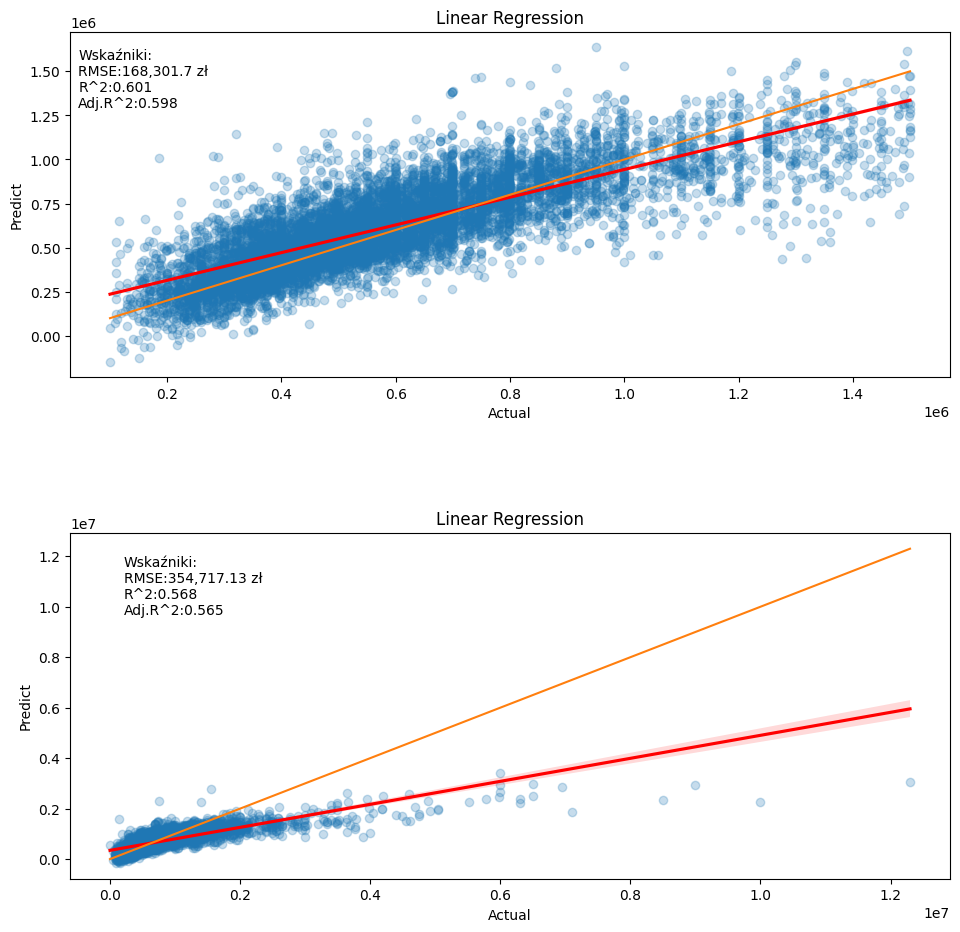

In [15]:
X_train = modeling_data['X_train']
y_train = modeling_data['y_train']

y_train_copy = y_train.copy()

linear = LinearRegression(n_jobs=-2)
y_train_copy[y_train_copy > 1_000_000] = y_train_copy[y_train_copy > 1_000_000]*1.3
linear.fit(X_train, y_train_copy)

model_summary(linear, "Linear Regression", modeling_data)

In [146]:
y_train[y_train > 1_000_000] = y_train[y_train > 1_000_000]*1.3

In [147]:
y_train

4068     611968.00
21202    993862.00
44497    379000.00
22440    565000.00
16880    699000.00
           ...    
42697    462001.32
36008   1697475.00
46265    334486.00
23587   1352000.00
29313    599000.00
Name: price, Length: 33509, dtype: float64

In [107]:
X_test = modeling_data['X_test_without_outliers']
y_test = modeling_data['y_test_without_outliers']

prediction = best_rf_model.predict(X_test)

low = y_test < 200_000
high = y_test > 1_200_000
        
mean_relative_error_low = np.mean((prediction[low] - y_test[low])/prediction[low])
mean_relative_error_high = np.mean((prediction[high] - y_test[high])/prediction[high])

print("Średni względny błąd:", round(mean_relative_error_low,2))
print("Średni względny błąd:", round(mean_relative_error_high,2))

Średni względny błąd: 0.33
Średni względny błąd: -0.29


### model_selection

In [ ]:
def model_selection(regressor, param_grid, modeling_data = modeling_data):
    
    # Załądowanie danych trainingowych
    X_train = modeling_data['X_train']
    y_train = modeling_data['y_train']
    X_test = modeling_data['X_test_without_outliers']
    y_test = modeling_data['y_test_without_outliers']

    # Inicjacja Grid Search z cross-validation
    rf_grid_search = GridSearchCV(estimator=regressor, param_grid=param_grid, cv=5,
                                          scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)

    # Dopasowanie Grid Search do danych treningowych
    rf_grid_search.fit(X_train, y_train)

    # Wybór najlepszego modelu
    best_model = rf_grid_search.best_estimator_

    # Ocena modelu na danych trenongowych
    train_score = best_model.score(X_train, y_train)
    print("Train Score:", train_score)

    # Ocena modelu na best_rf_model_primary testowych
    test_score = best_model.score(X_test, y_test)
    print("Test Score:", test_score)

    # Wyświetlenie najlepszych parametrów
    print("Najlepsze parametry:", rf_grid_search.best_params_)
        
    return best_model

# Choosing models

## Random Forest

In [130]:
# Definicja modelu Random Forest Regressor
rf_regressor = RandomForestRegressor(random_state=42, n_estimators=100)

# Definicja siatki parametrów do przeszukania
param_grid_rf = {
    'min_samples_leaf': [1, 5],
    'min_samples_split': [2, 5, 10],
    'max_features': [16, 32, 48],
    'max_depth': [30, 40, 50]
}

best_rf_model = model_selection(rf_regressor, param_grid_rf)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Train Score: 0.9754952073106236
Test Score: 0.8260234446413003
Najlepsze parametry: {'max_depth': 50, 'max_features': 32, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [16]:
best_rf_model = RandomForestRegressor(random_state=42, n_estimators=100,
                                      max_depth = 50, max_features = 32,
                                      min_samples_leaf = 1, min_samples_split = 2)
best_rf_model.fit(X_train, y_train)

,n_estimators,100
,criterion,'squared_error'
,max_depth,50
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,32
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


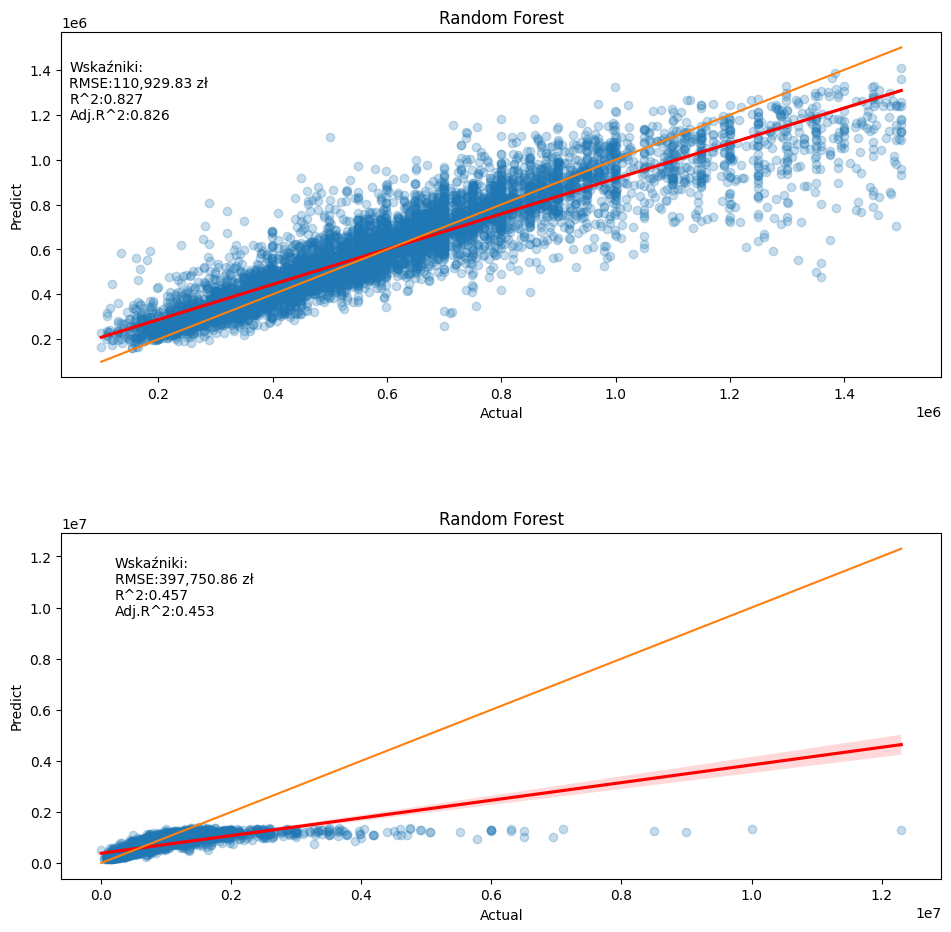

In [17]:
model_summary(best_rf_model, "Random Forest", modeling_data)

## XGBoost

In [131]:
xgboost_regressor = GradientBoostingRegressor(random_state=42, n_estimators=100)

# Definicja siatki parametrów do przeszukania
param_grid_xgboost = {
    'learning_rate': [0.01, 0.05, 0.1, 1],
    'subsample': [0.33, 0.5],
    'min_samples_leaf': [1],
    'min_samples_split': [2],
    'max_features': [32, 48, 64],
    'max_depth': [30, 40, 50, 60]
}

best_xgboost_model = model_selection(xgboost_regressor, param_grid_xgboost)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Train Score: 0.9984828405568079
Test Score: 0.8377101974777276
Najlepsze parametry: {'learning_rate': 0.05, 'max_depth': 30, 'max_features': 32, 'min_samples_leaf': 1, 'min_samples_split': 2, 'subsample': 0.5}


In [59]:
best_xgboost_model = GradientBoostingRegressor(random_state=42, n_estimators=100,
                                               learning_rate = 0.05,
                                               max_depth = 30, max_features = 32,
                                               min_samples_leaf = 1, min_samples_split = 2,
                                               subsample = 0.5)
best_xgboost_model.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.05, max_depth=30, max_features=32,
                          random_state=42, subsample=0.5)

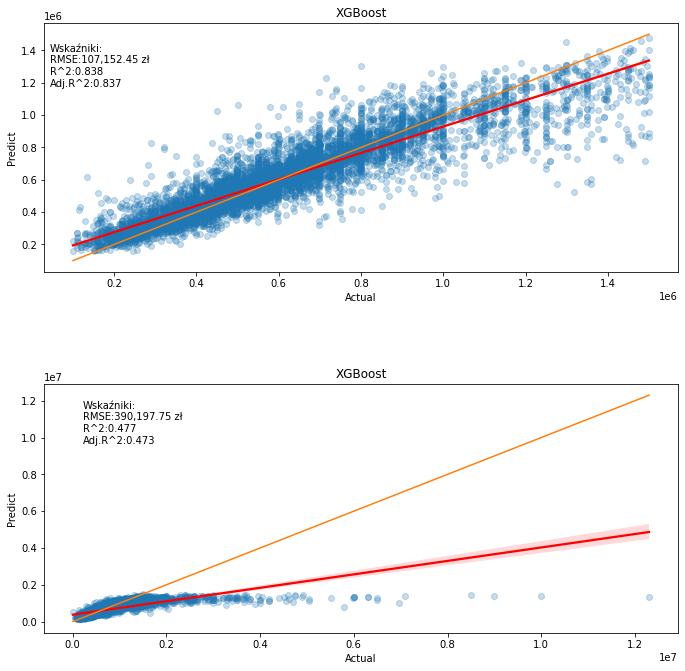

In [60]:
model_summary(best_xgboost_model, "XGBoost", modeling_data)

## KNNRegressor

In [132]:
# Definicja modelu Random Forest Regressor
knn_regressor = KNeighborsRegressor()

# Definicja siatki parametrów do przeszukania
param_grid_knn = {
    'n_neighbors': [5, 10, 20, 30, 50],
    'weights': ['uniform', 'distance'],
    'algorithm': ['ball_tree', 'kd_tree'],
    'leaf_size': [30, 50, 100, 200],
    'p': [1, 2]
}

best_knn_model = model_selection(knn_regressor, param_grid_knn)

Fitting 5 folds for each of 160 candidates, totalling 800 fits
Train Score: 0.9999038611308105
Test Score: 0.6863256255538606
Najlepsze parametry: {'algorithm': 'ball_tree', 'leaf_size': 100, 'n_neighbors': 10, 'p': 1, 'weights': 'distance'}


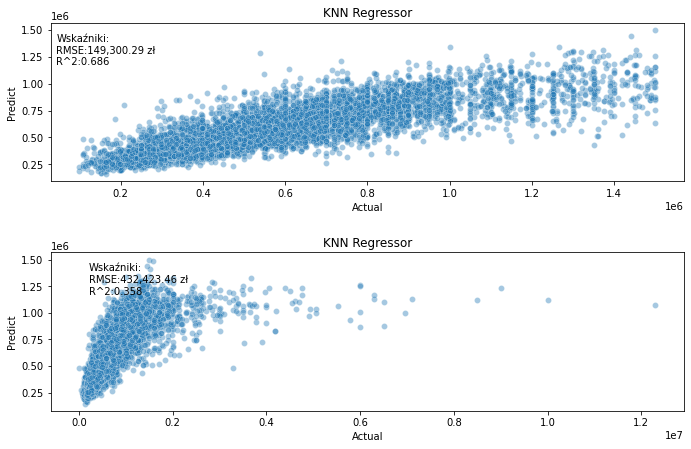

In [170]:
model_summary(best_knn_model, "KNN Regressor", modeling_data)

## MLPRegressor

In [ ]:
# Definicja modelu Random MLPRegressor
mlp_regressor = MLPRegressor(max_iter = 100, learning_rate = 'constant',
                             early_stopping = True, random_state = 99)

# Definicja siatki parametrów do przeszukania
param_grid_mlp = {
    'hidden_layer_sizes': [(200,2), (150,2), (150,1), (100,2), (25,2)],
    'learning_rate_init': [0.05, 0.1, 0.15],
    'n_iter_no_change': [2, 5]
}

best_mlp_model = model_selection(mlp_regressor, param_grid_mlp)

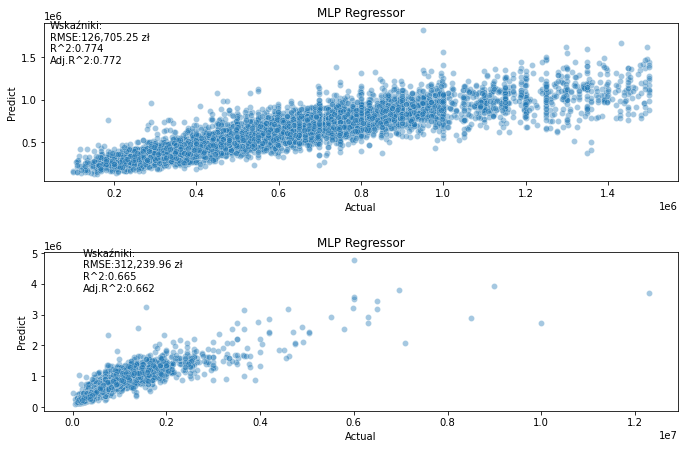

In [176]:
model_summary(best_mlp_model, "MLP Regressor", modeling_data)